In [19]:
import numpy as np
import h5py
import tensorflow as tf

def normalize_events(events):    
    return events / events.max()

# Normalize truths independently
def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max


# Load data
with h5py.File('/home/filippo/DUNE/data/numu-CC-QE/lightweight_dataset_15cm.h5', 'r') as f:
    events = f['inputs'][:]    # Load all inputs into memory
    truths = f['targets'][:]   # Load all targets into memory

# ----------------------------
# 1. Normalize inputs to [0, 1]
# ----------------------------
normalized_events = normalize_events(events)
normalized_truths = normalize_truths(truths)
# Inputs: (N, 60)
X = normalized_events

# Targets: (N, 2, 4, 5) with values in [0, 1]
y = normalized_truths

# ---- Build the model ----
input_dim = 60
#output_shape = (2, 4, 5)
output_shape = (4, 8, 9)

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(input_dim,)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(np.prod(output_shape), activation='sigmoid'),
#     tf.keras.layers.Reshape(output_shape)
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(input_dim,)),
    
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
    
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
    
#     tf.keras.layers.Dense(64, activation='relu'),
    
#     tf.keras.layers.Dense(np.prod(output_shape), activation='sigmoid'),
#     tf.keras.layers.Reshape(output_shape)
# ])

def normalize_output(x):
    max_val = tf.reduce_max(x, axis=[1, 2, 3], keepdims=True)
    return x / (max_val + 1e-6)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(np.prod(output_shape), activation='relu'),
    tf.keras.layers.Reshape(output_shape),
    tf.keras.layers.Lambda(normalize_output)
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# ---- Train the model ----

history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 288)            │        18,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 4, 8, 9)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 4, 8, 9)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,320 (204.38 KB)

 Trainable params: 51,808 (202.38 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0324 - mae: 0.0718 - val_loss: 0.0110 - val_mae: 0.0170
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - mae: 0.0178 - val_loss: 0.0104 - val_mae: 0.0146
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - mae: 0.0151 - val_loss: 0.0102 - val_mae: 0.0142
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - mae: 0.0146 - val_loss: 0.0102 - val_mae: 0.0142
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - mae: 0.0145 - val_loss: 0.0101 - val_mae: 0.0143
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - mae: 0.0144 - val_loss: 0.0101 - val_mae: 0.0144
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - mae: 0.0146 - val_loss: 0.0100 - val_mae: 0.0144
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - mae: 0.0143 - val_loss: 0.0100 - val_mae: 0.0143
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - mae:

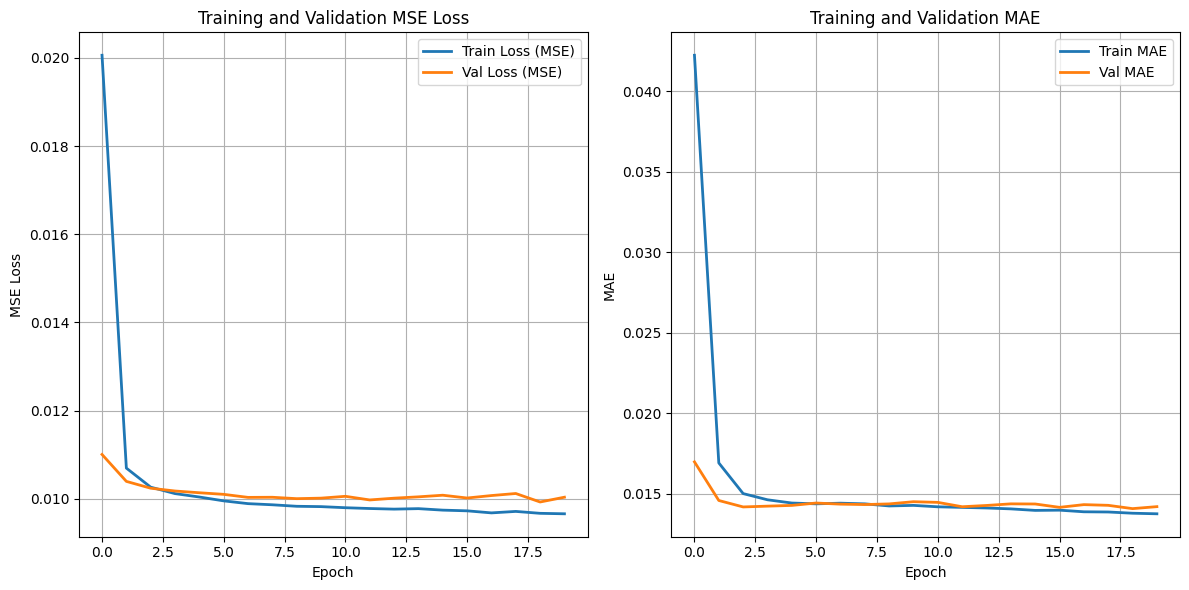

In [20]:
import matplotlib.pyplot as plt

# ---- Plot loss and MAE curves ----

plt.figure(figsize=(12, 6))

# Plot MSE Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)', lw=2)
plt.plot(history.history['val_loss'], label='Val Loss (MSE)', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', lw=2)
plt.plot(history.history['val_mae'], label='Val MAE', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


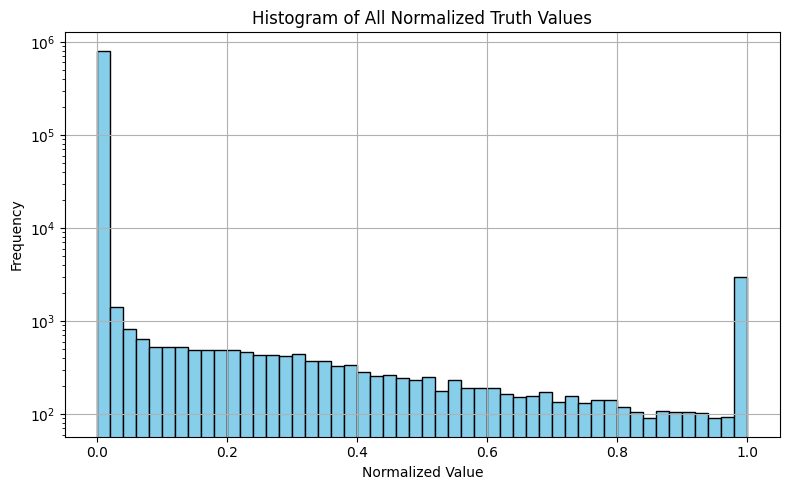

In [21]:
# Flatten all values in normalized_truths into a 1D array
all_values = normalized_truths.flatten()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_values, bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of All Normalized Truth Values')
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


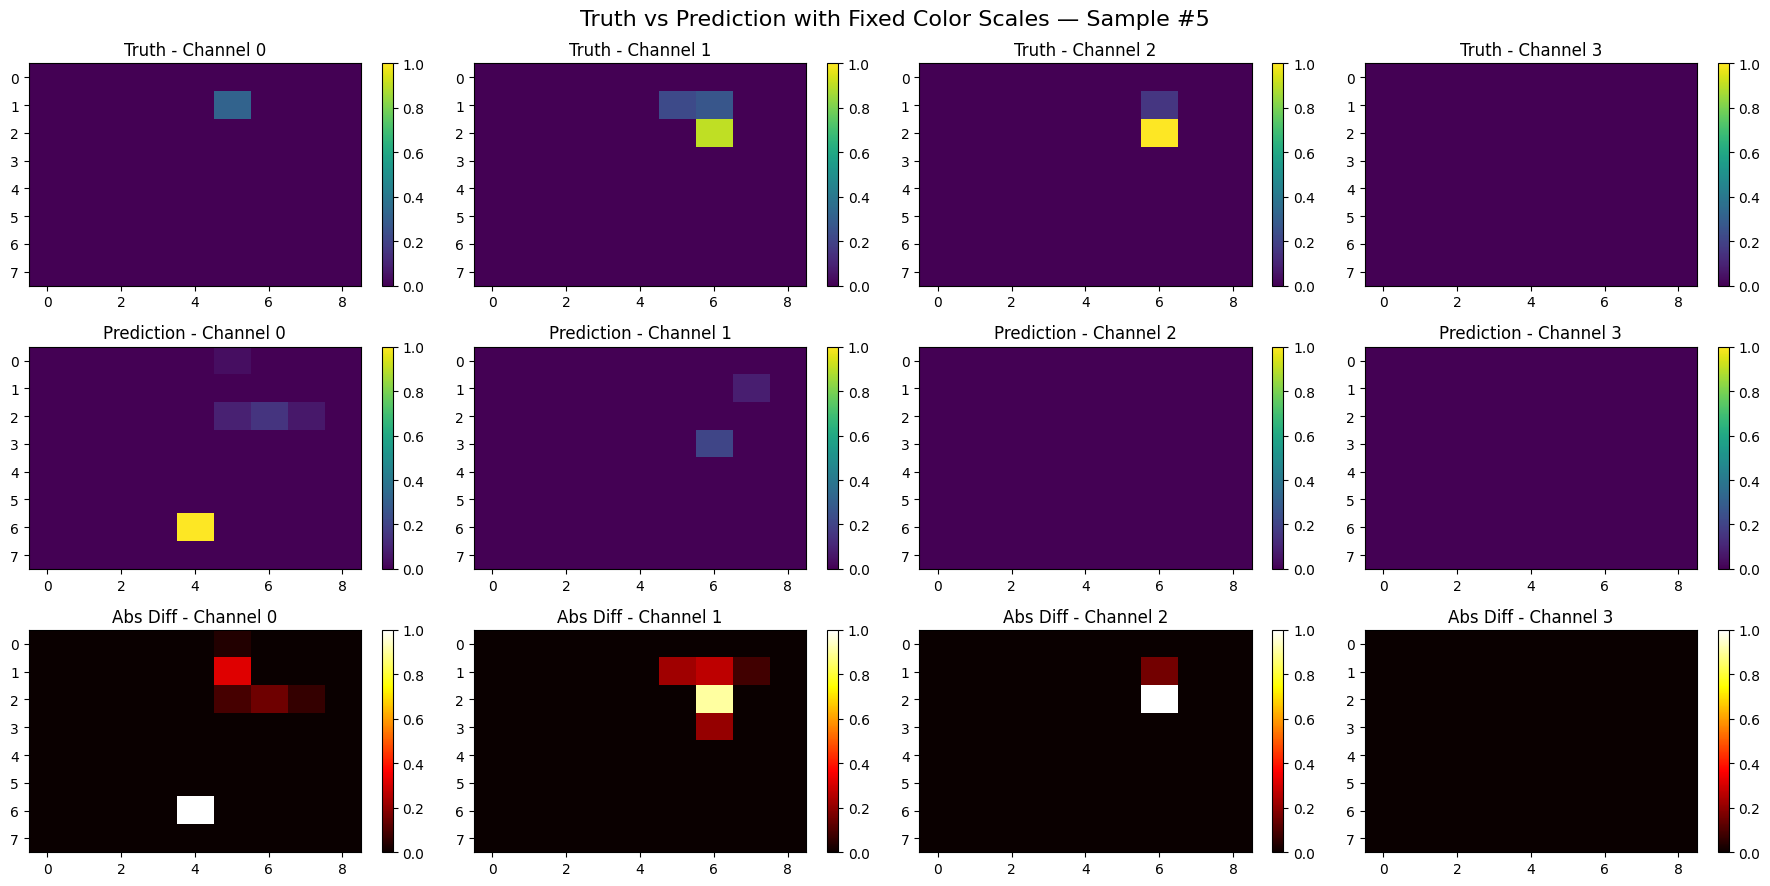

In [ ]:
def plot_truth_vs_pred(truth, pred, sample_idx=0):
    fig, axes = plt.subplots(3, 4, figsize=(18, 9))

    for i in range(4):
        # Truth (fixed scale 0–1)
        im0 = axes[0, i].imshow(truth[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'Truth - Channel {i}')
        plt.colorbar(im0, ax=axes[0, i])

        # Prediction (fixed scale 0–1)
        im1 = axes[1, i].imshow(pred[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'Prediction - Channel {i}')
        plt.colorbar(im1, ax=axes[1, i])

        # Absolute Difference (fixed scale 0–1, or tweak if needed)
        im2 = axes[2, i].imshow(np.abs(truth[i] - pred[i]), cmap='hot', aspect='auto', vmin=0, vmax=1)
        axes[2, i].set_title(f'Abs Diff - Channel {i}')
        plt.colorbar(im2, ax=axes[2, i])

    plt.suptitle(f'Truth vs Prediction with Fixed Color Scales — Sample #{sample_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Get one prediction
sample_idx = 6
truth_sample = y[sample_idx]                                 
predicted = model.predict(X[sample_idx:sample_idx+1])[0]
plot_truth_vs_pred(y[sample_idx], predicted, sample_idx)